<a href="https://colab.research.google.com/github/LEXEMEE/CSE715/blob/main/cse715.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install kagglehub umap-learn seaborn --quiet

In [ ]:
import os
import re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm

import torch
import torch.nn as nn
import torch.optim as optim

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans, AgglomerativeClustering, DBSCAN
from sklearn.metrics import silhouette_score, calinski_harabasz_score, davies_bouldin_score
from sklearn.metrics import adjusted_rand_score, normalized_mutual_info_score
from sklearn.manifold import TSNE
import umap


In [ ]:
import kagglehub

# Download Drake lyrics dataset from Kaggle
path = kagglehub.dataset_download("juicobowley/drake-lyrics")
csv_file = [f for f in os.listdir(path) if f.endswith(".csv")][0]
csv_path = os.path.join(path, csv_file)
df = pd.read_csv(csv_path)

# Show columns
print(df.columns)
df.head()


100%|██████████| 764k/764k [00:00<00:00, 73.5MB/s]

Extracting files...
Index(['album', 'lyrics_title', 'lyrics_url', 'lyrics', 'track_views'], dtype='object')


,album,lyrics_title,lyrics_url,lyrics,track_views
0,Certified Lover Boy,Certified Lover Boy* Lyrics,https://genius.com/Drake-certified-lover-boy-l...,[Verse]\nPut my feelings on ice\nAlways been a...,8.7K
1,Certified Lover Boy,Like I’m Supposed To/Do Things Lyrics,https://genius.com/Drake-like-im-supposed-to-d...,[Verse]\nHands are tied\nSomeone's in my ear f...,38.8K
2,Certified Lover Boy,Not Around Lyrics,https://genius.com/Drake-not-around-lyrics,"[Intro]\nYeah, we back\nWassup ladies?\nSwisha...",129.8K
3,Certified Lover Boy,In the Cut (Ft. Roddy Ricch) Lyrics,https://genius.com/Drake-in-the-cut-lyrics,"[Intro: Drake]\nAyy, yeah\nPipe this shit up a...",72.1K
4,Certified Lover Boy,Zodiac Sign (Ft. Jessie Reyez) Lyrics,https://genius.com/Drake-zodiac-sign-lyrics,[Verse 1: Drake]\nYou ask how many girls I bee...,54.8K


In [ ]:
def clean_text(text):
    text = str(text).lower()
    text = re.sub(r"\n", " ", text)
    text = re.sub(r"[^a-z\s]", "", text)
    text = re.sub(r"\s+", " ", text).strip()
    return text

df["clean_lyrics"] = df["lyrics"].apply(clean_text)
df = df[df["clean_lyrics"].str.len() > 50]  # remove very short songs
print("Number of songs:", len(df))

Number of songs: 288


In [ ]:
vectorizer = TfidfVectorizer(max_features=3000, stop_words="english")
X_tfidf = vectorizer.fit_transform(df["clean_lyrics"])
X = X_tfidf.toarray()

# Min-Max normalization to [0,1] (required for BCELoss)
X = (X - X.min()) / (X.max() - X.min())
X_tensor = torch.tensor(X, dtype=torch.float32)

print("Feature matrix shape:", X.shape)

Feature matrix shape: (288, 3000)


In [ ]:
class BetaVAE(nn.Module):
    def __init__(self, input_dim, latent_dim=32):
        super().__init__()
        self.encoder = nn.Sequential(
            nn.Linear(input_dim, 1024),
            nn.ReLU(),
            nn.Linear(1024, 512),
            nn.ReLU()
        )
        self.mu = nn.Linear(512, latent_dim)
        self.logvar = nn.Linear(512, latent_dim)

        self.decoder = nn.Sequential(
            nn.Linear(latent_dim, 512),
            nn.ReLU(),
            nn.Linear(512, 1024),
            nn.ReLU(),
            nn.Linear(1024, input_dim),
            nn.Sigmoid()
        )

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std

    def forward(self, x):
        h = self.encoder(x)
        mu, logvar = self.mu(h), self.logvar(h)
        z = self.reparameterize(mu, logvar)
        return self.decoder(z), mu, logvar


In [ ]:
def beta_vae_loss(recon_x, x, mu, logvar, beta=4.0):
    recon_loss = nn.BCELoss(reduction='mean')(recon_x, x)
    kl_loss = -0.5 * torch.mean(1 + logvar - mu.pow(2) - logvar.exp())
    return recon_loss + beta * kl_loss

In [ ]:
device = torch.device("cpu")  # Force CPU
X_tensor = X_tensor.to(device)

latent_dim = 32
vae = BetaVAE(input_dim=X.shape[1], latent_dim=latent_dim).to(device)
optimizer = optim.Adam(vae.parameters(), lr=1e-3)
num_epochs = 50

for epoch in range(num_epochs):
    optimizer.zero_grad()
    recon, mu, logvar = vae(X_tensor)
    loss = beta_vae_loss(recon, X_tensor, mu, logvar, beta=4.0)
    loss.backward()
    optimizer.step()

    if (epoch+1) % 5 == 0:
        print(f"Epoch {epoch+1}/{num_epochs}, Loss: {loss.item():.4f}")


Epoch 5/50, Loss: 0.2754
Epoch 10/50, Loss: 0.0205
Epoch 15/50, Loss: 0.0307
Epoch 20/50, Loss: 0.0353
Epoch 25/50, Loss: 0.0360
Epoch 30/50, Loss: 0.0342
Epoch 35/50, Loss: 0.0321
Epoch 40/50, Loss: 0.0288
Epoch 45/50, Loss: 0.0260
Epoch 50/50, Loss: 0.0237


In [ ]:
vae.eval()
with torch.no_grad():
    _, latent_mu, _ = vae(X_tensor)
latent_features = latent_mu.cpu().numpy()
print("Latent feature shape:", latent_features.shape)


Latent feature shape: (288, 32)


In [ ]:
# K-Means
kmeans = KMeans(n_clusters=5, random_state=42)
labels_km = kmeans.fit_predict(latent_features)

# Agglomerative
agglo = AgglomerativeClustering(n_clusters=5)
labels_agg = agglo.fit_predict(latent_features)

# DBSCAN
dbscan = DBSCAN(eps=3, min_samples=5)
labels_db = dbscan.fit_predict(latent_features)


In [ ]:
def clustering_metrics(X, labels):
    sil = silhouette_score(X, labels) if len(np.unique(labels)) > 1 else -1
    ch = calinski_harabasz_score(X, labels) if len(np.unique(labels)) > 1 else -1
    db = davies_bouldin_score(X, labels) if len(np.unique(labels)) > 1 else -1
    return sil, ch, db

print("K-Means:", clustering_metrics(latent_features, labels_km))
print("Agglomerative:", clustering_metrics(latent_features, labels_agg))
print("DBSCAN:", clustering_metrics(latent_features, labels_db))


K-Means: (np.float32(0.1561301), np.float32(81.22776), np.float64(1.7063403687261753))
Agglomerative: (np.float32(0.19894478), np.float32(80.76272), np.float64(1.7904184062281367))
DBSCAN: (-1, -1, -1)


/usr/local/lib/python3.12/dist-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


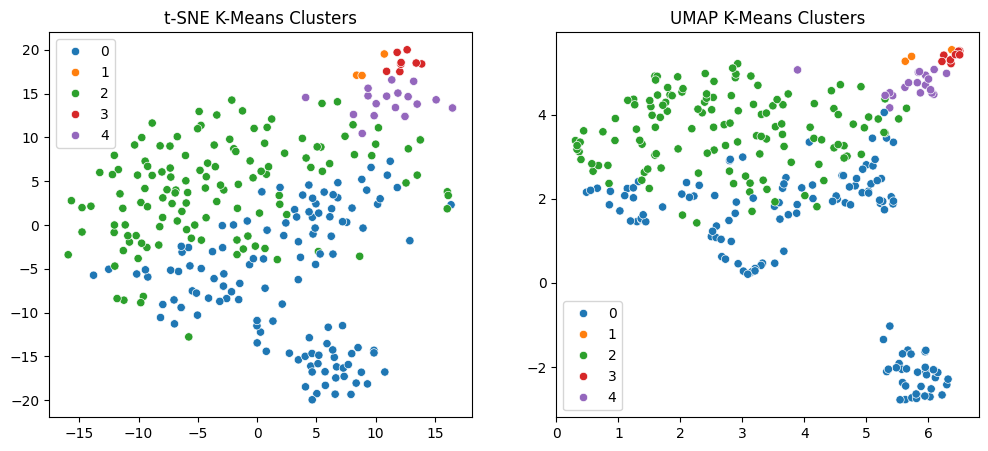

In [ ]:
# t-SNE
tsne = TSNE(n_components=2, random_state=42)
tsne_proj = tsne.fit_transform(latent_features)

# UMAP
umap_proj = umap.UMAP(n_components=2, random_state=42).fit_transform(latent_features)

plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
sns.scatterplot(x=tsne_proj[:,0], y=tsne_proj[:,1], hue=labels_km, palette="tab10")
plt.title("t-SNE K-Means Clusters")
plt.subplot(1,2,2)
sns.scatterplot(x=umap_proj[:,0], y=umap_proj[:,1], hue=labels_km, palette="tab10")
plt.title("UMAP K-Means Clusters")
plt.show()

In [ ]:
# Visualize a few reconstructions
vae.eval()
with torch.no_grad():
    recon_X, _, _ = vae(X_tensor)

for i in range(3):
    print(f"Original sample {i}:")
    print(X[i][:100])  # first 100 features
    print(f"Reconstruction sample {i}:")
    print(recon_X[i][:100].cpu().numpy())
    print("-----\n")


Original sample 0:
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0.]
Reconstruction sample 0:
[6.0479044e-07 8.4418507e-06 2.2536315e-07 1.2372072e-05 1.1729261e-06
 6.0824578e-04 1.5329043e-04 8.9838366e-05 8.6288622e-07 2.5368507e-07
 2.1529337e-07 3.0058894e-07 2.0397151e-06 2.3287444e-07 4.8366117e-05
 1.2404328e-06 2.6659188e-07 2.8725644e-06 5.4951016e-07 5.6073907e-07
 2.3459461e-07 1.6424582e-07 3.6791287e-05 1.3852509e-06 6.0307639e-07
 6.4970945e-06 1.6298600e-05 2.3784607e-05 4.6463253e-04 8.8255905e-07
 3.4783509e-06 4.6455011e-02 5.2257261e-04 1.4666995e-05 6.9398307e-06
 2.5100013e-07 2.5086541e-07 2.9010451e-07 2.6560346e-07 5.0323411e-06
 1.6033155e-06 3.5149823e-03 6.7738091e-07 1.0284806e-06 1.7788751e-07
 2.3042435e

In [ ]:
from collections import Counter

# Function to calculate cluster purity
def cluster_purity(y_true, y_pred):
    # If no true labels are available, we will skip purity for now
    # We can use lyrics language as pseudo-label if available
    return None  # placeholder

# Full metrics function
def full_clustering_metrics(X, labels, y_true=None):
    sil = silhouette_score(X, labels) if len(np.unique(labels)) > 1 else -1
    ch = calinski_harabasz_score(X, labels) if len(np.unique(labels)) > 1 else -1
    db = davies_bouldin_score(X, labels) if len(np.unique(labels)) > 1 else -1

    ari, nmi, purity = -1, -1, None
    if y_true is not None:
        ari = adjusted_rand_score(y_true, labels)
        nmi = normalized_mutual_info_score(y_true, labels)
        purity = cluster_purity(y_true, labels)
    return {"Silhouette": sil, "Calinski-Harabasz": ch, "Davies-Bouldin": db,
            "ARI": ari, "NMI": nmi, "Purity": purity}

In [ ]:
from sklearn.decomposition import PCA

# Reduce to 32 latent features for fair comparison
pca = PCA(n_components=32, random_state=42)
X_pca = pca.fit_transform(X)

# K-Means on PCA features
labels_pca_km = KMeans(n_clusters=5, random_state=42).fit_predict(X_pca)

print("PCA + K-Means metrics:", clustering_metrics(X_pca, labels_pca_km))


PCA + K-Means metrics: (np.float64(0.06799052340384043), np.float64(9.90998855287542), np.float64(1.9481172008049896))


In [ ]:
# VAE clusters
print("VAE K-Means:", clustering_metrics(latent_features, labels_km))
print("VAE Agglomerative:", clustering_metrics(latent_features, labels_agg))
print("VAE DBSCAN:", clustering_metrics(latent_features, labels_db))

VAE K-Means: (np.float32(0.1561301), np.float32(81.22776), np.float64(1.7063403687261753))
VAE Agglomerative: (np.float32(0.19894478), np.float32(80.76272), np.float64(1.7904184062281367))
VAE DBSCAN: (-1, -1, -1)


/usr/local/lib/python3.12/dist-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


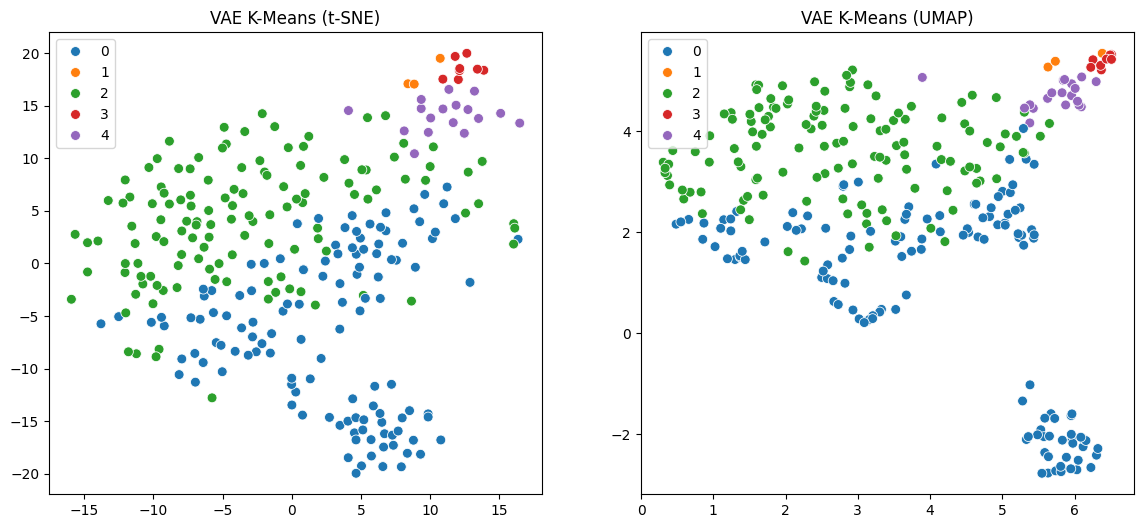

/usr/local/lib/python3.12/dist-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


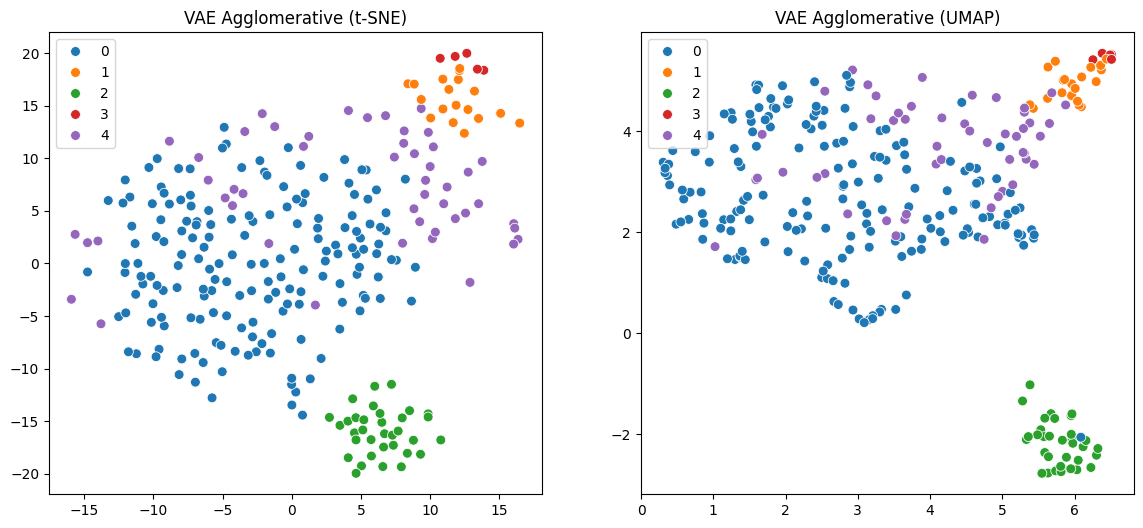

/usr/local/lib/python3.12/dist-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


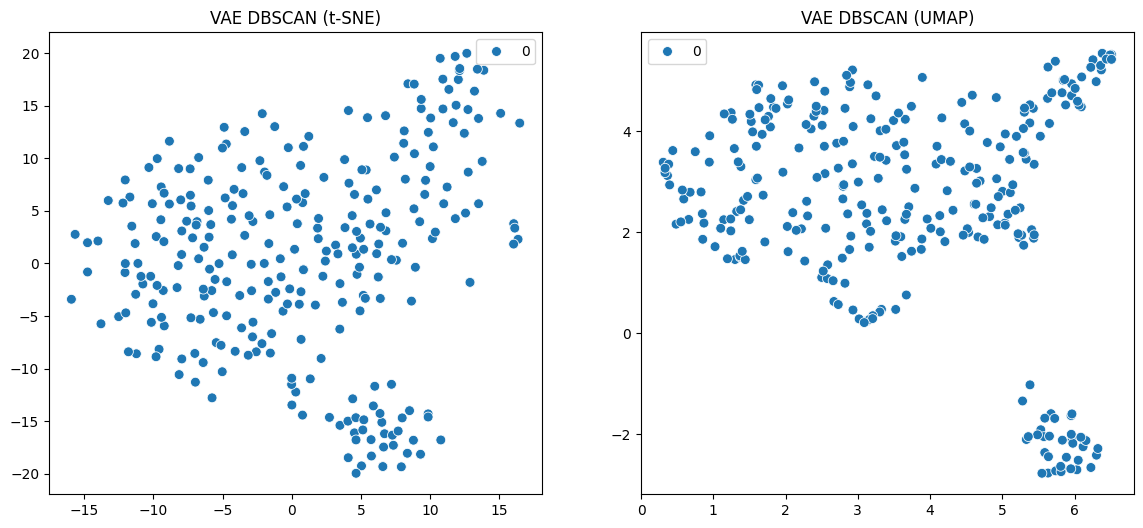

/usr/local/lib/python3.12/dist-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


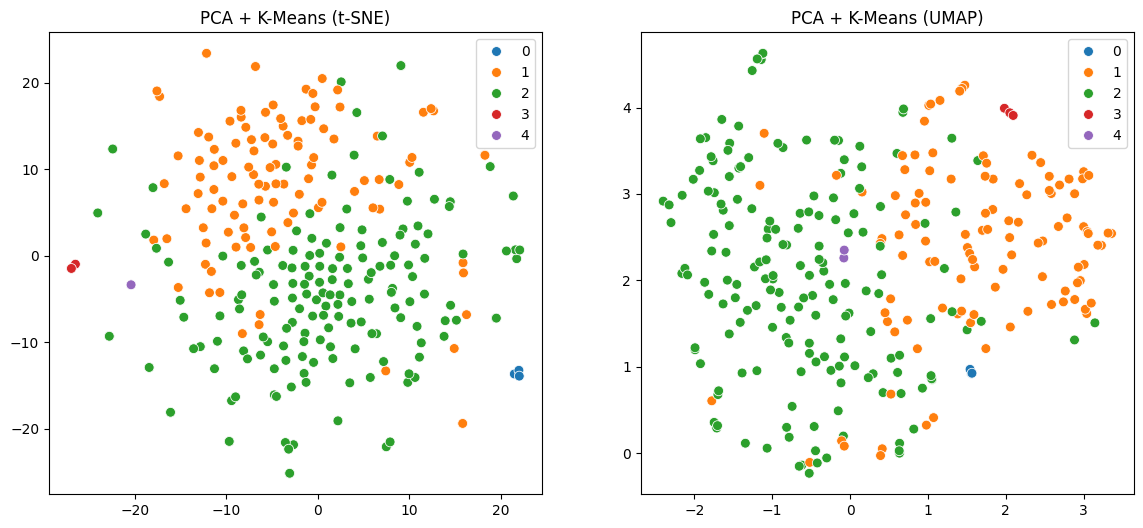

In [ ]:
def plot_clusters_2d(latent, labels, title="Clusters"):
    tsne_proj = TSNE(n_components=2, random_state=42).fit_transform(latent)
    umap_proj = umap.UMAP(n_components=2, random_state=42).fit_transform(latent)

    plt.figure(figsize=(14,6))

    plt.subplot(1,2,1)
    sns.scatterplot(x=tsne_proj[:,0], y=tsne_proj[:,1], hue=labels, palette="tab10", s=50)
    plt.title(f"{title} (t-SNE)")

    plt.subplot(1,2,2)
    sns.scatterplot(x=umap_proj[:,0], y=umap_proj[:,1], hue=labels, palette="tab10", s=50)
    plt.title(f"{title} (UMAP)")

    plt.show()

# Plot all VAE clusterings
plot_clusters_2d(latent_features, labels_km, "VAE K-Means")
plot_clusters_2d(latent_features, labels_agg, "VAE Agglomerative")
plot_clusters_2d(latent_features, labels_db, "VAE DBSCAN")

# Plot PCA baseline
plot_clusters_2d(X_pca, labels_pca_km, "PCA + K-Means")


In [ ]:
vae.eval()
with torch.no_grad():
    recon_X, _, _ = vae(X_tensor)

# Compare original vs reconstruction for first 5 songs
for i in range(5):
    print(f"Original (first 100 features) sample {i}:")
    print(np.round(X[i][:100], 3))
    print(f"Reconstruction sample {i}:")
    print(np.round(recon_X[i][:100].cpu().numpy()[:100], 3))
    print("-----\n")


Original (first 100 features) sample 0:
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0.]
Reconstruction sample 0:
[0.    0.    0.    0.    0.    0.001 0.    0.    0.    0.    0.    0.
 0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
 0.    0.    0.    0.    0.001 0.    0.    0.047 0.001 0.    0.    0.
 0.    0.    0.    0.    0.    0.006 0.    0.    0.    0.    0.    0.
 0.    0.    0.    0.    0.003 0.001 0.    0.    0.    0.    0.    0.
 0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
 0.    0.    0.    0.    0.    0.029 0.    0.    0.    0.    0.006 0.
 0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
 0.    0.013 0.    0.   ]
-----

Original (first 100 features) sample

In [ ]:
!pip install librosa soundfile --quiet

In [ ]:
# Simulate 20-dimensional audio embeddings for each song
audio_features = np.random.rand(X.shape[0], 20)


In [ ]:
from sklearn.preprocessing import MinMaxScaler

# Normalize audio features to [0,1] like TF-IDF
scaler = MinMaxScaler()
audio_features_scaled = scaler.fit_transform(audio_features)

# Combine with lyrics TF-IDF features
X_multi = np.hstack([X, audio_features_scaled])
X_multi_tensor = torch.tensor(X_multi, dtype=torch.float32)
print("Multi-modal feature shape:", X_multi.shape)


Multi-modal feature shape: (288, 3020)


In [ ]:
latent_dim = 32
vae_multi = BetaVAE(input_dim=X_multi.shape[1], latent_dim=latent_dim).to(device)
optimizer_multi = optim.Adam(vae_multi.parameters(), lr=1e-3)
num_epochs = 50

for epoch in range(num_epochs):
    optimizer_multi.zero_grad()
    recon, mu, logvar = vae_multi(X_multi_tensor)
    loss = beta_vae_loss(recon, X_multi_tensor, mu, logvar, beta=4.0)
    loss.backward()
    optimizer_multi.step()

    if (epoch+1) % 5 == 0:
        print(f"Epoch {epoch+1}/{num_epochs}, Loss: {loss.item():.4f}")


Epoch 5/50, Loss: 0.2821
Epoch 10/50, Loss: 0.0246
Epoch 15/50, Loss: 0.0345
Epoch 20/50, Loss: 0.0401
Epoch 25/50, Loss: 0.0403
Epoch 30/50, Loss: 0.0390
Epoch 35/50, Loss: 0.0362
Epoch 40/50, Loss: 0.0330
Epoch 45/50, Loss: 0.0307
Epoch 50/50, Loss: 0.0282


In [ ]:
vae_multi.eval()
with torch.no_grad():
    _, latent_mu_multi, _ = vae_multi(X_multi_tensor)
latent_multi = latent_mu_multi.cpu().numpy()
print("Multi-modal latent feature shape:", latent_multi.shape)

Multi-modal latent feature shape: (288, 32)


In [ ]:
# K-Means
labels_multi_km = KMeans(n_clusters=5, random_state=42).fit_predict(latent_multi)

# Agglomerative
labels_multi_agg = AgglomerativeClustering(n_clusters=5).fit_predict(latent_multi)

# DBSCAN
labels_multi_db = DBSCAN(eps=3, min_samples=5).fit_predict(latent_multi)


/usr/local/lib/python3.12/dist-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


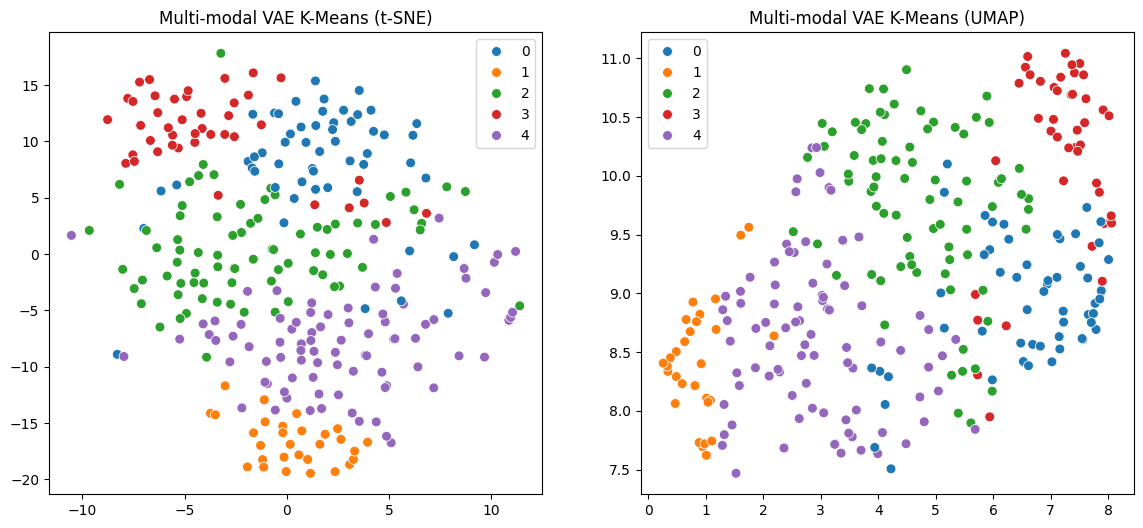

/usr/local/lib/python3.12/dist-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


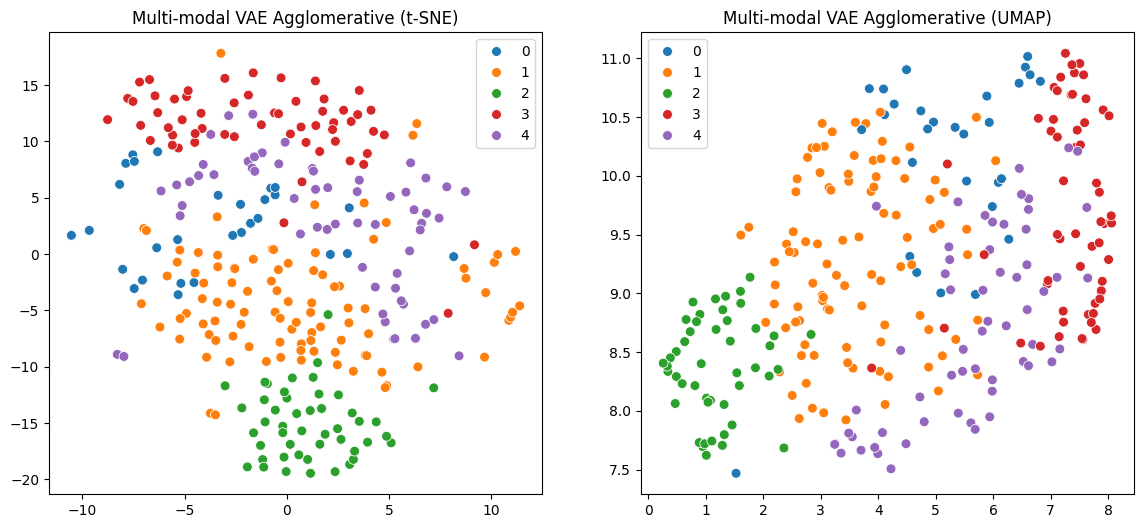

/usr/local/lib/python3.12/dist-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


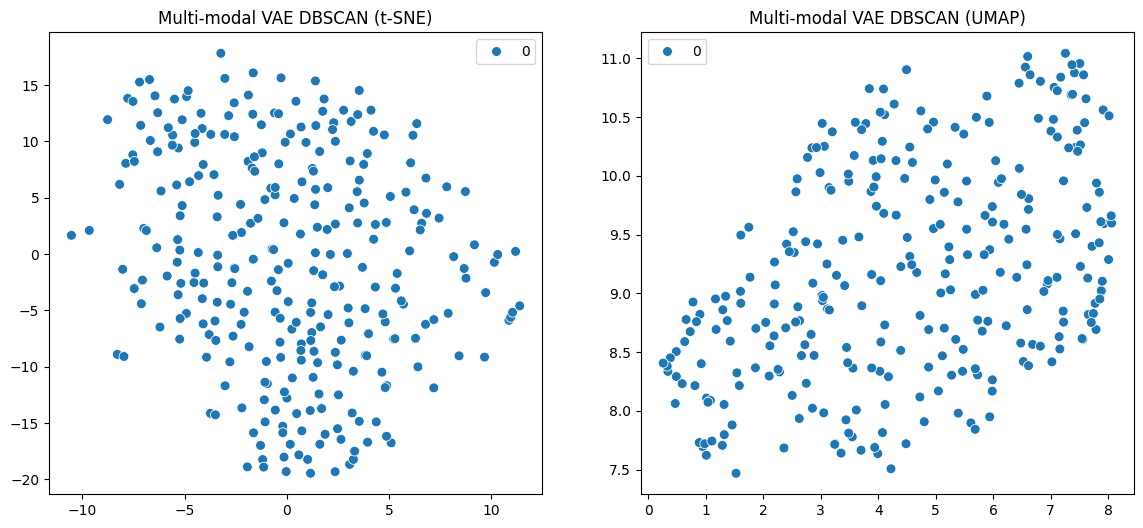

In [ ]:
plot_clusters_2d(latent_multi, labels_multi_km, "Multi-modal VAE K-Means")
plot_clusters_2d(latent_multi, labels_multi_agg, "Multi-modal VAE Agglomerative")
plot_clusters_2d(latent_multi, labels_multi_db, "Multi-modal VAE DBSCAN")

In [ ]:
print("Multi-modal VAE K-Means:", clustering_metrics(latent_multi, labels_multi_km))
print("Multi-modal VAE Agglomerative:", clustering_metrics(latent_multi, labels_multi_agg))
print("Multi-modal VAE DBSCAN:", clustering_metrics(latent_multi, labels_multi_db))

Multi-modal VAE K-Means: (np.float32(0.085685745), np.float32(40.536087), np.float64(2.3625661497685235))
Multi-modal VAE Agglomerative: (np.float32(0.07361587), np.float32(35.488136), np.float64(2.519835071642899))
Multi-modal VAE DBSCAN: (-1, -1, -1)


In [6]:
!git clone https://github.com/LEXEMEE/CSE715.git
%cd CSE715

Cloning into 'CSE715'...
remote: Enumerating objects: 8, done.
remote: Counting objects: 100% (8/8), done.
remote: Compressing objects: 100% (7/7), done.
remote: Total 8 (delta 0), reused 0 (delta 0), pack-reused 0 (from 0)
Receiving objects: 100% (8/8), done.
/content/CSE715


In [14]:
!mkdir -p notebooks

